<p style="font-size: 50px; line-height: 1.5; text-align: center;"> <font color='#191970'> Speech Emotion Recognition </font> </p>

<div style="display: flex; justify-content: center;"><img src="istockphoto-926750644-612x612.jpg" width=550px /></div>

###  <font color="grey"> <i>Note: The work in this notebook is partial. The goal of this notebook was to provide a general overview of the topic and to experiment with various techniques in order to gain a deeper understanding of these technologies. Accordingly, the workflow was purely experimental and the accuracy of the results was not the main focus. Therefore, there may be some details that are not explained or incomplete. Please keep this in mind when reviewing the code and results.</i> </font>

# Installing Missing Libraries

In [1]:
%%capture
!pip install --upgrade pip
!pip install --upgrade setuptools
!pip install --upgrade librosa
!pip install hmmlearn
!pip install visualkeras

## Importing Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
from collections import defaultdict
import visualkeras
from PIL import ImageFont

# Data Prep. for model training
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from scipy.ndimage import gaussian_filter
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

# Traditional ML Models Framework
from hmmlearn.hmm import GaussianHMM
from sklearn.mixture import BayesianGaussianMixture
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# Deep Learning Learning Framework
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Dense, LSTM, Bidirectional, Reshape, Flatten, ActivityRegularization, GRU
from keras.layers import Activation, Dot, GlobalAveragePooling1D
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Embedding, Concatenate, TimeDistributed
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D, Activation
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import regularizers
from tensorflow.keras.regularizers import l2, l1, l1_l2
from keras.utils import to_categorical
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping

import warnings; warnings.filterwarnings('ignore')

## Dataset Used: <b> RAVDESS Emotional speech audio </b>

<a href="https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio?resource=download" target="_blank">Click here to visit Dataset website</a>

## Feature Extraction Functions

In [3]:
# RAVDESS native sample rate is 48k
sample_rate = 48000

# Mel Spectrograms are not directly used as a feature in this model
# Mel Spectrograms are used in calculating MFCCs, which are a higher-level representation of pitch transition
# MFCCs work better - left the mel spectrogram function here in case anyone wants to experiment
def feature_melspectrogram(
    waveform, 
    sample_rate,
    fft = 1024,
    winlen = 512,
    window='hamming',
    hop=256,
    mels=128,
    ):
    
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram = librosa.feature.melspectrogram(
        y=waveform, 
        sr=sample_rate, 
        n_fft=fft, 
        win_length=winlen, 
        window=window, 
        hop_length=hop, 
        n_mels=mels, 
        fmax=sample_rate/2)
    
    # convert from power (amplitude**2) to decibels
    # necessary for network to learn - doesn't converge with raw power spectrograms 
    melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
    
    return melspectrogram

def feature_mfcc(
    waveform, 
    sample_rate,
    n_mfcc = 40,
    fft = 1024,
    winlen = 512,
    window='hamming',
    #hop=256, # increases # of time steps; was not helpful
    mels=128
    ):

    # Compute the MFCCs for all STFT frames 
    # 40 mel filterbanks (n_mfcc) = 40 coefficients
    mfc_coefficients=librosa.feature.mfcc(
        y=waveform, 
        sr=sample_rate, 
        n_mfcc=n_mfcc,
        n_fft=fft, 
        win_length=winlen, 
        window=window, 
        #hop_length=hop, 
        n_mels=mels, 
        fmax=sample_rate/2
        ) 

    return mfc_coefficients

def get_features(waveforms, features, samplerate):

    # initialize counter to track progress
    file_count = 0

    # process each waveform individually to get its MFCCs
    for waveform in waveforms:
        mfccs = feature_mfcc(waveform, sample_rate)
        features.append(mfccs)
        file_count += 1
        # print progress 
        print('\r'+f' Processed {file_count}/{len(waveforms)} waveforms',end='')
    
    # return all features from list of waveforms
    return features

def get_waveforms(file):
    
    # load an individual sample audio file
    # read the full 3 seconds of the file, cut off the first 0.5s of silence; native sample rate = 48k
    # don't need to store the sample rate that librosa.load returns
    waveform, _ = librosa.load(file, duration=3, offset=0.5, sr=sample_rate)
    
    # make sure waveform vectors are homogenous by defining explicitly
    waveform_homo = np.zeros((int(sample_rate*3,)))
    waveform_homo[:len(waveform)] = waveform
    
    # return a single file's waveform                                      
    return waveform_homo

# RAVDESS dataset emotions
emotions_dict ={
    '0':'surprised',
    '1':'neutral',
    '2':'calm',
    '3':'happy',
    '4':'sad',
    '5':'angry',
    '6':'fearful',
    '7':'disgust'
}

# Additional attributes from RAVDESS 
emotion_attributes = {
    '01': 'normal',
    '02': 'strong'
}

## Build Dataset

In [62]:
# Define the path to the parent folder containing the 24 folders
parent_folder = "/Users/USER/Desktop/archive"

# Define a dictionary to map the numerical identifiers to their labels
label_dict = {
    "modality": {"01": "full-AV", "02": "video-only", "03": "audio-only"},
    "vocal_channel": {"01": "speech", "02": "song"},
    "emotion": {"01": "neutral", "02": "calm", "03": "happy", "04": "sad", "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"},
    "intensity": {"01": "normal", "02": "strong"},
    "statement": {"01": "Kids are talking by the door", "02": "Dogs are sitting by the door"},
    "repetition": {"01": "1st repetition", "02": "2nd repetition"}
}

# Define an empty list to store the extracted information
data = []

# Loop over each folder in the parent folder
for folder_name in os.listdir(parent_folder):
    if not os.path.isdir(os.path.join(parent_folder, folder_name)):
        continue
    
    # Loop over each audio file in the current folder
    for filename in os.listdir(os.path.join(parent_folder, folder_name)):
        if not filename.endswith(".wav"):
            continue
        
        # Extract the relevant information from the filename
        parts = filename.split("-")
        modality = label_dict["modality"][parts[0]]
        vocal_channel = label_dict["vocal_channel"][parts[1]]
        emotion = label_dict["emotion"][parts[2]]
        intensity = label_dict["intensity"][parts[3]]
        statement = label_dict["statement"][parts[4]]
        repetition = label_dict["repetition"][parts[5]]
        actor_num = int(parts[6].split(".")[0])
        actor_sex = "male" if actor_num % 2 == 1 else "female"
        
        # Append the extracted information to the data list
        data.append([modality, vocal_channel, emotion, intensity, statement, repetition, actor_num, actor_sex])

# Create a pandas DataFrame from the data list
data = pd.DataFrame(data, columns=["modality", "vocal_channel", "emotion", "intensity", "statement", "repetition", "actor_num", "actor_sex"])

# Print the first few rows of the DataFrame
data.head(10)

modality vocal_channel  emotion intensity                     statement  \
0  audio-only        speech  neutral    normal  Kids are talking by the door   
1  audio-only        speech  neutral    normal  Kids are talking by the door   
2  audio-only        speech  neutral    normal  Dogs are sitting by the door   
3  audio-only        speech  neutral    normal  Dogs are sitting by the door   
4  audio-only        speech     calm    normal  Kids are talking by the door   
5  audio-only        speech     calm    normal  Kids are talking by the door   
6  audio-only        speech     calm    normal  Dogs are sitting by the door   
7  audio-only        speech     calm    normal  Dogs are sitting by the door   
8  audio-only        speech     calm    strong  Kids are talking by the door   
9  audio-only        speech     calm    strong  Kids are talking by the door   

       repetition  actor_num actor_sex  
0  1st repetition          1      male  
1  2nd repetition          1      male  
2  1st repetition          1      male  
3  2nd repetition          1      male  
4  1st repetition          1      male  
5  2nd repetition          1      male  
6  1st repetition          1      male  
7  2nd repetition          1      male  
8  1st repetition          1      male  
9  2nd repetition          1      male

In [63]:
# raw waveform
waveforms = []

# loop over each subfolder in the parent folder
for folder in os.listdir(parent_folder):
    folder_path = os.path.join(parent_folder, folder)
    # loop over each audio file in the current subfolder
    for audio_file in os.listdir(folder_path):
        # check if the file is a .wav file
        if audio_file.endswith('.wav'):
            audio_path = os.path.join(folder_path, audio_file)
            # apply the get_waveform function on the audio file
            waveform = get_waveforms(audio_path)
            waveforms.append(waveform)
            
data['waveform'] = waveforms

In [64]:
paths = []

# loop over each subfolder in the parent folder
for folder in os.listdir(parent_folder):
    folder_path = os.path.join(parent_folder, folder)
    # loop over each audio file in the current subfolder
    for audio_file in os.listdir(folder_path):
        # check if the file is a .wav file
        if audio_file.endswith('.wav'):
            audio_path = os.path.join(folder_path, audio_file)
            paths.append(audio_path)
            
data['speech'] = paths

In [7]:
print(f'Waveforms set: {len(waveforms)} samples')
# we have 1440 waveforms but we need to know their length too; should be 3 sec * 48k = 144k
print(f'Waveform signal length: {len(waveforms[0])}')

Waveforms set: 1440 samples
Waveform signal length: 144000


In [65]:
# initialize feature array
# We extract MFCC features from waveforms and store in 'features' array
features = []

data['mfcc'] = get_features(waveforms, features, sample_rate)

 Processed 1440/1440 waveforms

In [66]:
data.head(10)

modality vocal_channel  emotion intensity                     statement  \
0  audio-only        speech  neutral    normal  Kids are talking by the door   
1  audio-only        speech  neutral    normal  Kids are talking by the door   
2  audio-only        speech  neutral    normal  Dogs are sitting by the door   
3  audio-only        speech  neutral    normal  Dogs are sitting by the door   
4  audio-only        speech     calm    normal  Kids are talking by the door   
5  audio-only        speech     calm    normal  Kids are talking by the door   
6  audio-only        speech     calm    normal  Dogs are sitting by the door   
7  audio-only        speech     calm    normal  Dogs are sitting by the door   
8  audio-only        speech     calm    strong  Kids are talking by the door   
9  audio-only        speech     calm    strong  Kids are talking by the door   

       repetition  actor_num actor_sex  \
0  1st repetition          1      male   
1  2nd repetition          1      male   
2  1st repetition          1      male   
3  2nd repetition          1      male   
4  1st repetition          1      male   
5  2nd repetition          1      male   
6  1st repetition          1      male   
7  2nd repetition          1      male   
8  1st repetition          1      male   
9  2nd repetition          1      male   

                                            waveform  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 3.0517578125e-05, 0....   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
7  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
9  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              speech  \
0  /Users/USER/Desktop/archive\Actor_01\03-01-01-...   
1  /Users/USER/Desktop/archive\Actor_01\03-01-01-...   
2  /Users/USER/Desktop/archive\Actor_01\03-01-01-...   
3  /Users/USER/Desktop/archive\Actor_01\03-01-01-...   
4  /Users/USER/Desktop/archive\Actor_01\03-01-02-...   
5  /Users/USER/Desktop/archive\Actor_01\03-01-02-...   
6  /Users/USER/Desktop/archive\Actor_01\03-01-02-...   
7  /Users/USER/Desktop/archive\Actor_01\03-01-02-...   
8  /Users/USER/Desktop/archive\Actor_01\03-01-02-...   
9  /Users/USER/Desktop/archive\Actor_01\03-01-02-...   

                                                mfcc  
0  [[-1001.3932749662753, -1001.3932749662753, -1...  
1  [[-991.081171202478, -989.5370761616882, -990....  
2  [[-988.3008575798004, -988.3008575798004, -988...  
3  [[-989.790157887361, -989.790157887361, -989.7...  
4  [[-1020.813650186152, -1020.813650186152, -102...  
5  [[-1012.2387947359822, -1012.2387947359822, -1...  
6  [[-1028.1853255084611, -1024.1363038764512, -1...  
7  [[-1017.2354807128509, -1017.2354807128509, -1...  
8  [[-1054.1579893737517, -1054.1579893737517, -1...  
9  [[-1028.0295452403195, -1028.0295452403195, -1...

## Explatory Data Analysis

In [10]:
def waveshow(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion,size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.show()

In [11]:
counts = data['emotion'].value_counts()
counts

calm         192
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
neutral       96
Name: emotion, dtype: int64

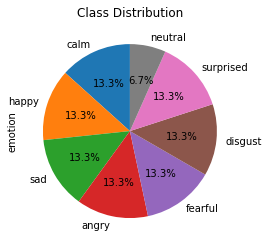

In [12]:
# plot the counts as a pie chart with labels
counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, labels=counts.index)

# add a title
plt.title('Class Distribution')
plt.show()

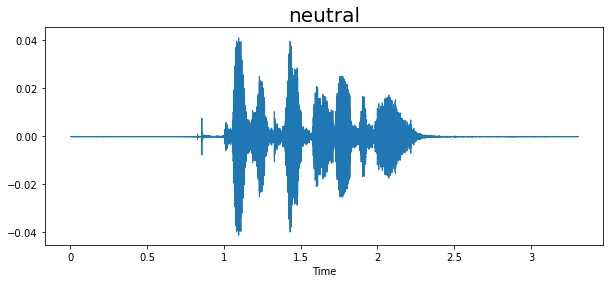

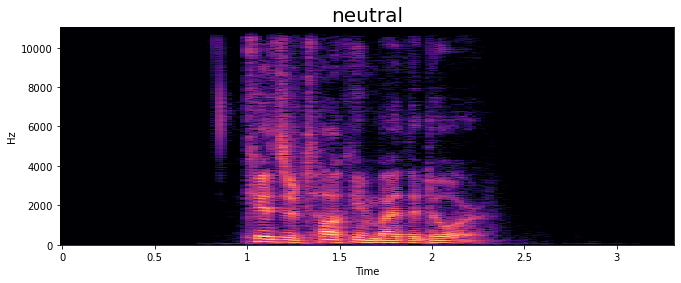

In [13]:
emotion = 'neutral'
path = data['speech'][data['emotion']==emotion][0]
d, sampling_rate = librosa.load(path)
waveshow(d, sampling_rate, emotion)
spectogram(d, sampling_rate, emotion)
Audio(path)

In [14]:
data['speech'][data['emotion']=='angry'][28]

'/Users/USER/Desktop/archive\\Actor_01\\03-01-05-01-01-01-01.wav'

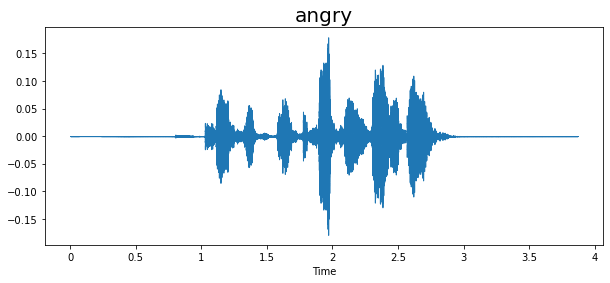

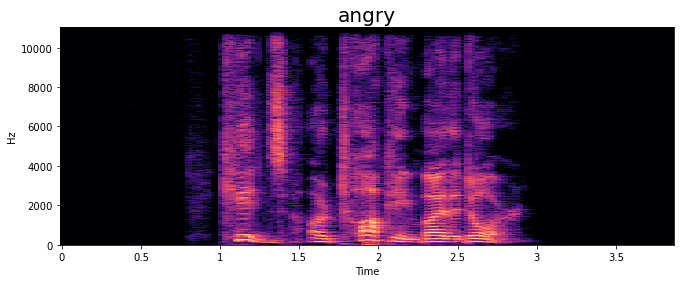

In [15]:
emotion = 'angry'
path = np.array(data['speech'][data['emotion']==emotion])[0]
d, sampling_rate = librosa.load(path)
waveshow(d, sampling_rate, emotion)
spectogram(d, sampling_rate, emotion)
Audio(path)

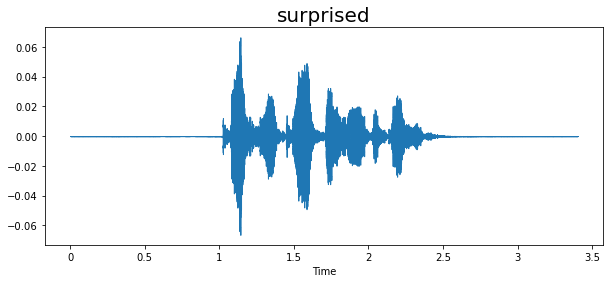

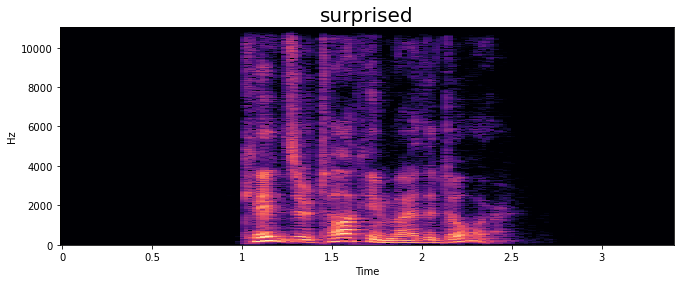

In [16]:
emotion = 'surprised'
path = np.array(data['speech'][data['emotion']==emotion])[0]
d, sampling_rate = librosa.load(path)
waveshow(d, sampling_rate, emotion)
spectogram(d, sampling_rate, emotion)
Audio(path)

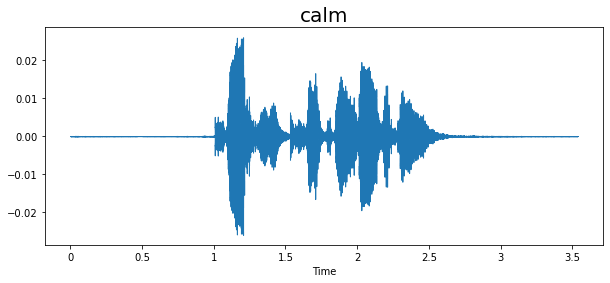

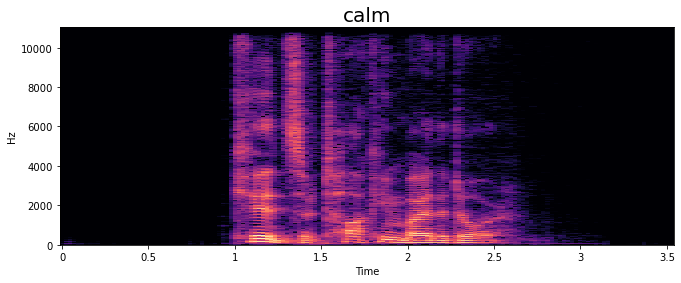

In [17]:
emotion = 'calm'
path = np.array(data['speech'][data['emotion']==emotion])[0]
d, sampling_rate = librosa.load(path)
waveshow(d, sampling_rate, emotion)
spectogram(d, sampling_rate, emotion)
Audio(path)

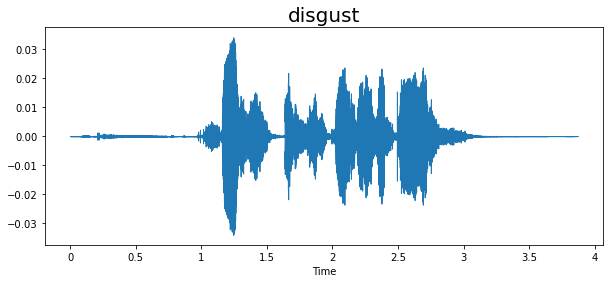

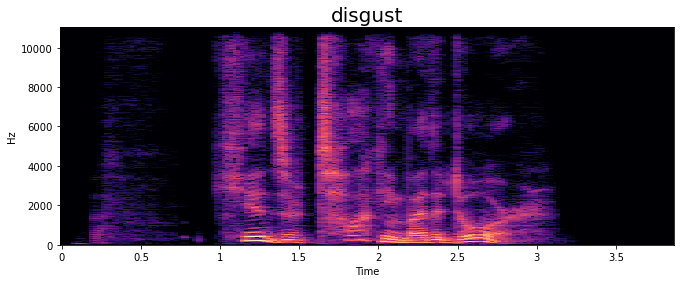

In [18]:
emotion = 'disgust'
path = np.array(data['speech'][data['emotion']==emotion])[0]
d, sampling_rate = librosa.load(path)
waveshow(d, sampling_rate, emotion)
spectogram(d, sampling_rate, emotion)
Audio(path)

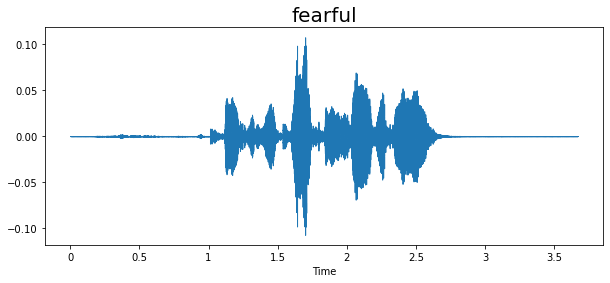

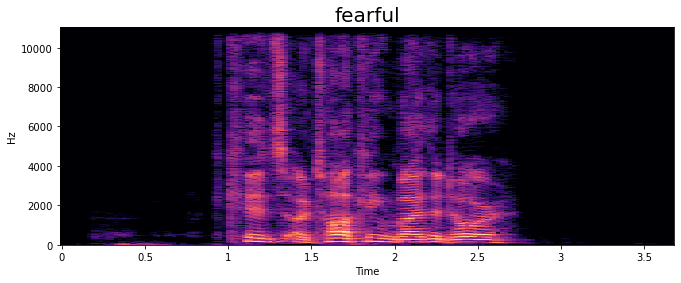

In [19]:
emotion = 'fearful'
path = np.array(data['speech'][data['emotion']==emotion])[0]
d, sampling_rate = librosa.load(path)
waveshow(d, sampling_rate, emotion)
spectogram(d, sampling_rate, emotion)
Audio(path)

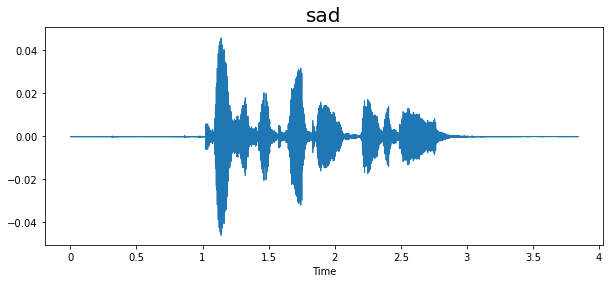

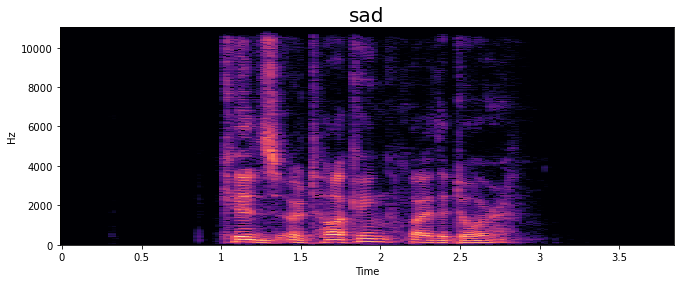

In [20]:
emotion = 'sad'
path = np.array(data['speech'][data['emotion']==emotion])[0]
d, sampling_rate = librosa.load(path)
waveshow(d, sampling_rate, emotion)
spectogram(d, sampling_rate, emotion)
Audio(path)

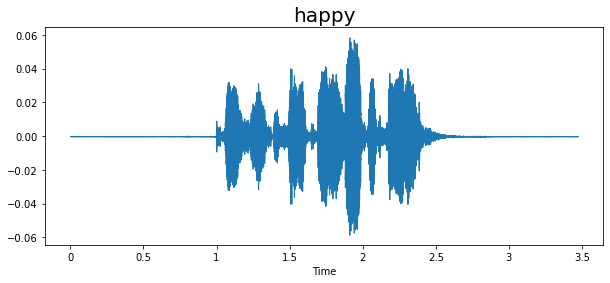

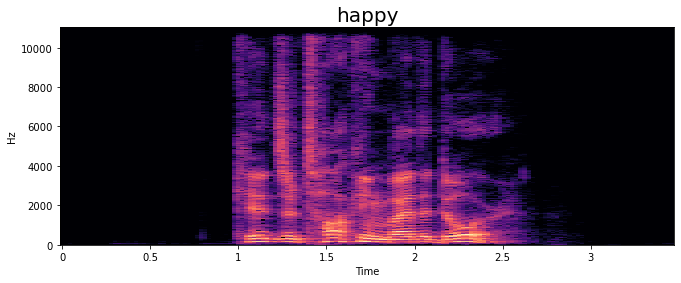

In [21]:
emotion = 'happy'
path = np.array(data['speech'][data['emotion']==emotion])[0]
d, sampling_rate = librosa.load(path)
waveshow(d, sampling_rate, emotion)
spectogram(d, sampling_rate, emotion)
Audio(path)

## Preprocessing

In [22]:
def awgn_augmentation(waveform, multiples=2, bits=16, snr_min=15, snr_max=30): 
    
    # get length of waveform (should be 3*48k = 144k)
    wave_len = len(waveform)
    
    # Generate normally distributed (Gaussian) noises
    # one for each waveform and multiple (i.e. wave_len*multiples noises)
    noise = np.random.normal(size=(multiples, wave_len))
    
    # Normalize waveform and noise
    norm_constant = 2.0**(bits-1)
    norm_wave = waveform / norm_constant
    norm_noise = noise / norm_constant
    
    # Compute power of waveform and power of noise
    signal_power = np.sum(norm_wave ** 2) / wave_len
    noise_power = np.sum(norm_noise ** 2, axis=1) / wave_len
    
    # Choose random SNR in decibels in range [15,30]
    snr = np.random.randint(snr_min, snr_max)
    
    # Apply whitening transformation: make the Gaussian noise into Gaussian white noise
    # Compute the covariance matrix used to whiten each noise 
    # actual SNR = signal/noise (power)
    # actual noise power = 10**(-snr/10)
    covariance = np.sqrt((signal_power / noise_power) * 10 ** (- snr / 10))
    # Get covariance matrix with dim: (144000, 2) so we can transform 2 noises: dim (2, 144000)
    covariance = np.ones((wave_len, multiples)) * covariance

    # Since covariance and noise are arrays, * is the haddamard product 
    # Take Haddamard product of covariance and noise to generate white noise
    multiple_augmented_waveforms = waveform + covariance.T * noise
    
    return multiple_augmented_waveforms

def augment_waveforms(waveforms, features, emotions, multiples):
    # keep track of how many waveforms we've processed so we can add correct emotion label in the same order
    emotion_count = 0
    # keep track of how many augmented samples we've added
    added_count = 0
    # convert emotion array to list for more efficient appending
    emotions = emotions.tolist()

    for waveform in waveforms:

        # Generate 2 augmented multiples of the dataset, i.e. 1440 native + 1440*2 noisy = 4320 samples total
        augmented_waveforms = awgn_augmentation(waveform, multiples=multiples)

        # compute spectrogram for each of 2 augmented waveforms
        for augmented_waveform in augmented_waveforms:

            # Compute MFCCs over augmented waveforms
            augmented_mfcc = feature_mfcc(augmented_waveform, sample_rate=sample_rate)

            # append the augmented spectrogram to the rest of the native data
            features.append(augmented_mfcc)
            emotions.append(emotions[emotion_count])

            # keep track of new augmented samples
            added_count += 1

            # check progress
            print('\r'+f'Processed {emotion_count + 1}/{len(waveforms)} waveforms for {added_count}/{len(waveforms)*multiples} new augmented samples',end='')

        # keep track of the emotion labels to append in order
        emotion_count += 1
        
        # store augmented waveforms to check their shape
        augmented_waveforms_temp.append(augmented_waveforms)
    
    return features, emotions

In [67]:
# store augmented waveforms to verify their shape and random-ness
augmented_waveforms_temp = []

# specify multiples of our dataset to add as augmented data
multiples = 2

# define labels
y = data['emotion']

features, y = augment_waveforms(waveforms, features, y, multiples)

Processed 1440/1440 waveforms for 2880/2880 new augmented samples

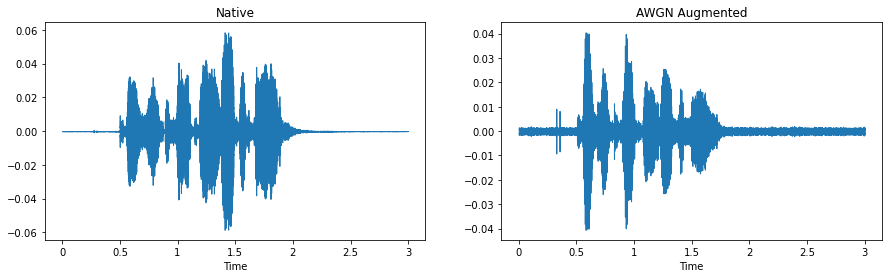

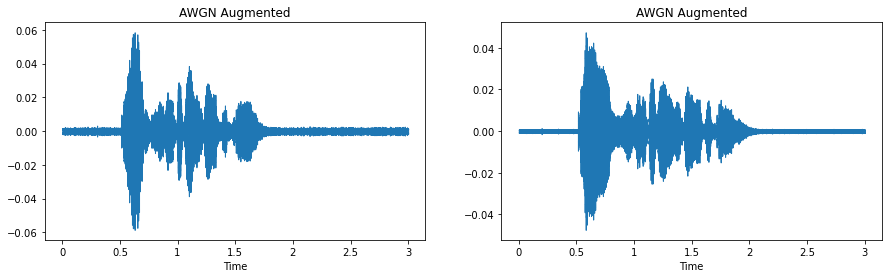

In [24]:
# pick a random waveform, but same one from native and augmented set for easier comparison
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
librosa.display.waveshow(waveforms[12], sr=sample_rate)
plt.title('Native')

plt.subplot(1, 2, 2)
# augmented waveforms are 2D len 1440 list with 2 waveforms in each position
librosa.display.waveshow(augmented_waveforms_temp[0][0], sr=sample_rate)
plt.title('AWGN Augmented')
plt.show()

plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
librosa.display.waveshow(augmented_waveforms_temp[2][0], sr=sample_rate)
plt.title('AWGN Augmented')

plt.subplot(1, 2, 2)
librosa.display.waveshow(augmented_waveforms_temp[7][0], sr=sample_rate)
plt.title('AWGN Augmented')
plt.show()

In [68]:
# need to make dummy input channel for CNN input feature tensor
X = np.expand_dims(features, 1)
X = np.reshape(X, (X.shape[0], 40, 282, 1))

# encode the array with numerical values based on the dictionary
inverted_dict = {v: k for k, v in emotions_dict.items()}
y = np.array([inverted_dict[x] for x in y])

# perform one-hot encoding
y = to_categorical(y)

In [26]:
X.shape

(4320, 40, 282, 1)

In [27]:
# free up some RAM - no longer need full feature set or any waveforms 
del features, waveforms, augmented_waveforms_temp

In [69]:
scaler = StandardScaler()

# store shape so we can transform it back 
i,j,k,w = X.shape

# Reshape to 1D because StandardScaler operates on a 1D array
# tell numpy to infer shape of 1D array with '-1' argument
X = np.reshape(X, (i,-1)) 
X = scaler.fit_transform(X)

# Transform back to NxCxHxW 4D tensor format
X = np.reshape(X, (i,j,k,w))

# Create Deep Learning Models

<div style="display: flex; justify-content: center;"><img src="0_tqQ-x7QM2zKhJB9F.jpg" width=700px/></div>

In [70]:
# Creating train & validation data splits
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=69)

## CNN-LSTM Model

In [30]:
# Defining the DNN model
def build_model(input_shape):
    
    # *** Sequential Model ****
    model = Sequential()
    
    model.add(Input(shape=input_shape))

    # Reshape the features
    model.add(Reshape((-1, input_shape[1], 1)))
     
    # Joint Feature Extraction from CNN 
    model.add(Conv2D(8, (3, 3), activation='relu'))
    model.add(AveragePooling2D((3, 3), strides=(2, 2), padding='valid'))
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(AveragePooling2D((3, 3), strides=(2, 2), padding='valid'))
    
    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(AveragePooling2D((2, 2), strides=(2, 2), padding='valid'))
    
    model.add(Reshape((-1,64)))
              
    # Structural Feature Extraction from LSTM
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))
    
    #Batch Normalization
    model.add(BatchNormalization())
    
    # Dense Layers
    model.add(Dense(32, use_bias=True, kernel_initializer="glorot_uniform", kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Activation('selu'))
    
    # Activation Layer
    model.add(Dense(8, use_bias=True, kernel_initializer="glorot_uniform", kernel_regularizer=l2(0.01)))
    model.add(Activation('softmax'))

    # compile model
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)
    model.compile(optimizer=Nadam(learning_rate=1e-4), loss=loss, metrics=['categorical_accuracy'])
    model.summary()
    
    return model

In [31]:
cnn_lstm_model = build_model((train_X.shape[1],train_X.shape[2]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 40, 282, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 38, 280, 8)        80        
                                                                 
 average_pooling2d (AverageP  (None, 18, 139, 8)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 137, 32)       2336      
                                                                 
 average_pooling2d_1 (Averag  (None, 7, 68, 32)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 67, 64)         8

## Visualize The Convolutional Layers

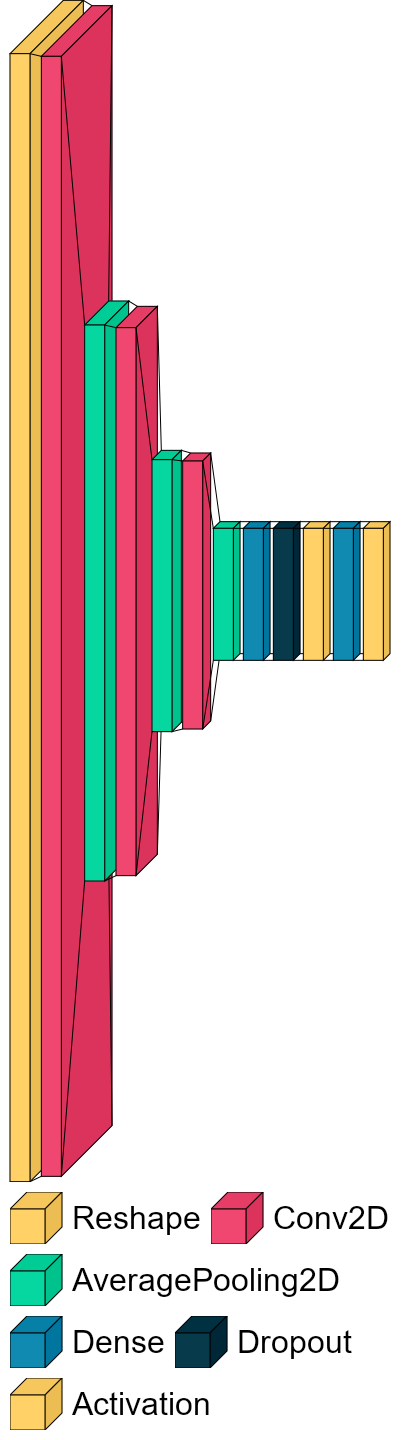

In [34]:

input_shape = (40,282)
# *** Sequential Model ****
model = Sequential()

model.add(Input(shape=input_shape))

# Reshape the features
model.add(Reshape((-1, input_shape[1], 1)))

# Joint Feature Extraction from CNN 
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(AveragePooling2D((3, 3), strides=(2, 2), padding='valid'))
model.add(visualkeras.SpacingDummyLayer())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(AveragePooling2D((3, 3), strides=(2, 2), padding='valid'))
model.add(visualkeras.SpacingDummyLayer())

model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(AveragePooling2D((2, 2), strides=(2, 2), padding='valid'))
model.add(visualkeras.SpacingDummyLayer())

# model.add(Reshape((-1,64)))

# # Structural Feature Extraction from LSTM
# model.add(Bidirectional(LSTM(64, return_sequences=True)))
# model.add(Bidirectional(LSTM(64)))

# #Batch Normalization
# model.add(BatchNormalization())

# Dense Layers
model.add(Dense(32, use_bias=True, kernel_initializer="glorot_uniform", kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Activation('selu'))

# Activation Layer
model.add(Dense(8, use_bias=True, kernel_initializer="glorot_uniform", kernel_regularizer=l2(0.01)))
model.add(Activation('softmax'))

# Now visualize the model!

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[Dropout]['fill'] = 'pink'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'
font = ImageFont.truetype("arial.ttf", 32)

# Generate a visualization of the model architecture
visualkeras.layered_view(model, to_file='CNN-LSTM.png', type_ignore=[visualkeras.SpacingDummyLayer], \
                        font=font, legend=True)



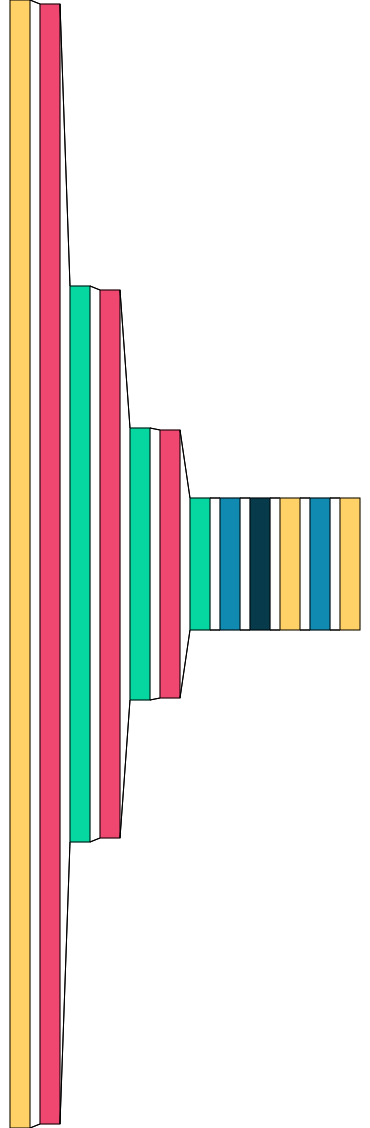

In [35]:
visualkeras.layered_view(model, draw_volume=False, type_ignore=[visualkeras.SpacingDummyLayer])

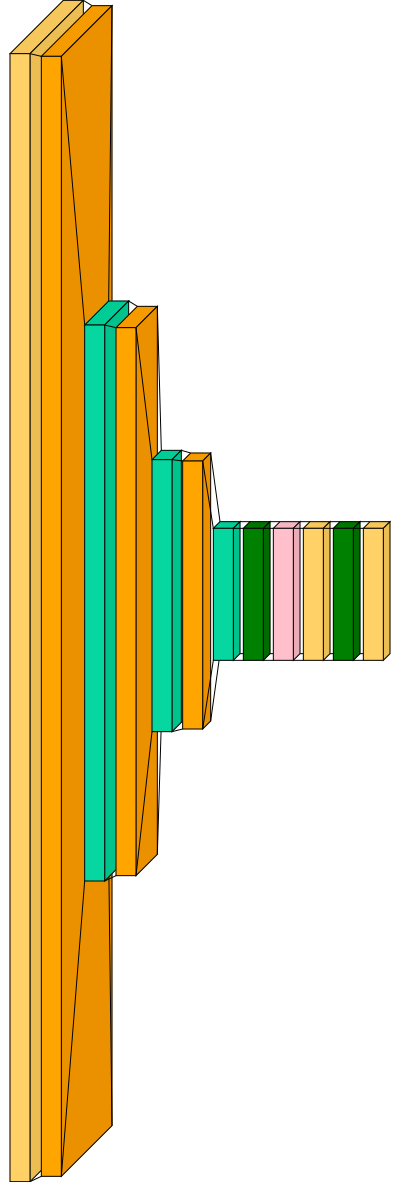

In [36]:
visualkeras.layered_view(model, color_map=color_map, type_ignore=[visualkeras.SpacingDummyLayer])

## Training Statistics 

In [37]:
# Detect GPU for accelerating the computation
gpus = tf.config.experimental.list_physical_devices('GPU')

if len(gpus) != 0:
    device = '/gpu:0'
else:
    device = '/cpu:0'
    
print (f'Computation Device: {device}')

Computation Device: /cpu:0


In [38]:
# Definition for training the Neural Model
def train(filename, model, epochs, batch_size, train_X, val_X, train_y, val_y):

    checkpoint = ModelCheckpoint(filename, monitor='val_categorical_accuracy',mode='max', save_best_only=True, verbose=1)
    
    tf.debugging.set_log_device_placement(True)
    
    with tf.device(device):
        print(f'Training on the device: {device}\n')
        history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X,val_y), callbacks= [checkpoint])
    return history

       
# Model training
EPOCHS = 100
BATCH_SIZE = 8

model_training = train('model.h5', cnn_lstm_model, EPOCHS, BATCH_SIZE, train_X, val_X, train_y, val_y)

Training on the device: /cpu:0

Epoch 1/100
432/432 [==============================] - ETA: 0s - loss: 2.5878 - categorical_accuracy: 0.2497
Epoch 1: val_categorical_accuracy improved from -inf to 0.21875, saving model to model.h5
432/432 [==============================] - 46s 92ms/step - loss: 2.5878 - categorical_accuracy: 0.2497 - val_loss: 2.5651 - val_categorical_accuracy: 0.2188
Epoch 2/100
432/432 [==============================] - ETA: 0s - loss: 2.4133 - categorical_accuracy: 0.3446
Epoch 2: val_categorical_accuracy did not improve from 0.21875
432/432 [==============================] - 39s 90ms/step - loss: 2.4133 - categorical_accuracy: 0.3446 - val_loss: 3.0242 - val_categorical_accuracy: 0.1516
Epoch 3/100
432/432 [==============================] - ETA: 0s - loss: 2.3155 - categorical_accuracy: 0.3715
Epoch 3: val_categorical_accuracy improved from 0.21875 to 0.39005, saving model to model.h5
432/432 [==============================] - 39s 90ms/step - loss: 2.3155 - categor

432/432 [==============================] - 39s 90ms/step - loss: 1.3739 - categorical_accuracy: 0.7468 - val_loss: 1.4484 - val_categorical_accuracy: 0.6817
Epoch 50/100
432/432 [==============================] - ETA: 0s - loss: 1.3659 - categorical_accuracy: 0.7529
Epoch 50: val_categorical_accuracy did not improve from 0.72106
432/432 [==============================] - 39s 90ms/step - loss: 1.3659 - categorical_accuracy: 0.7529 - val_loss: 1.5172 - val_categorical_accuracy: 0.6574
Epoch 51/100
432/432 [==============================] - ETA: 0s - loss: 1.3543 - categorical_accuracy: 0.7572
Epoch 51: val_categorical_accuracy did not improve from 0.72106
432/432 [==============================] - 49s 113ms/step - loss: 1.3543 - categorical_accuracy: 0.7572 - val_loss: 1.4393 - val_categorical_accuracy: 0.6887
Epoch 52/100
432/432 [==============================] - ETA: 0s - loss: 1.3458 - categorical_accuracy: 0.7598
Epoch 52: val_categorical_accuracy improved from 0.72106 to 0.72222, s

Epoch 74/100
432/432 [==============================] - ETA: 0s - loss: 1.2053 - categorical_accuracy: 0.8559
Epoch 74: val_categorical_accuracy improved from 0.78588 to 0.81250, saving model to model.h5
432/432 [==============================] - 71s 165ms/step - loss: 1.2053 - categorical_accuracy: 0.8559 - val_loss: 1.2619 - val_categorical_accuracy: 0.8125
Epoch 75/100
432/432 [==============================] - ETA: 0s - loss: 1.2048 - categorical_accuracy: 0.8394
Epoch 75: val_categorical_accuracy did not improve from 0.81250
432/432 [==============================] - 71s 165ms/step - loss: 1.2048 - categorical_accuracy: 0.8394 - val_loss: 1.2693 - val_categorical_accuracy: 0.7975
Epoch 76/100
432/432 [==============================] - ETA: 0s - loss: 1.2062 - categorical_accuracy: 0.8545
Epoch 76: val_categorical_accuracy did not improve from 0.81250
432/432 [==============================] - 74s 171ms/step - loss: 1.2062 - categorical_accuracy: 0.8545 - val_loss: 1.4287 - val_cat

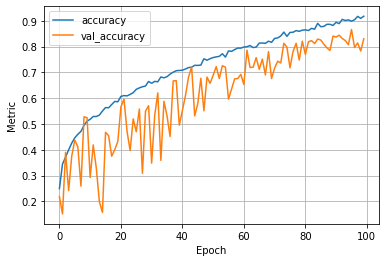

In [39]:
# Plot the training history
def dashboard(log):
    plt.figure()
    plt.plot(log.history["categorical_accuracy"], label="accuracy")
    plt.plot(log.history['val_categorical_accuracy'], label="val_accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.grid(True)
    plt.legend(loc='best')
 
dashboard(model_training)

In [40]:
cnn_lstm_model.evaluate(train_X, train_y)

108/108 [==============================] - 9s 67ms/step - loss: 1.0422 - categorical_accuracy: 0.9346


[1.042175531387329, 0.9346064925193787]

In [43]:
# make predictions on the test data
y_pred = cnn_lstm_model.predict(val_X)

# convert the predictions and true labels to class labels
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(val_y, axis=1)

# create a dataframe with y_pred and y_test as columns
compare_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

# add a third column indicating whether the prediction is true or false
compare_df['is_correct'] = np.where(compare_df['y_test'] == compare_df['y_pred'], 'true', 'false')

# display the dataframe
compare_df

27/27 [==============================] - 1s 33ms/step


y_test  y_pred is_correct
0         5       7      false
1         4       4       true
2         3       3       true
3         5       5       true
4         0       0       true
..      ...     ...        ...
859       7       7       true
860       5       5       true
861       2       2       true
862       4       4       true
863       4       4       true

[864 rows x 3 columns]

In [44]:
compare_df['is_correct'].value_counts()

true     717
false    147
Name: is_correct, dtype: int64

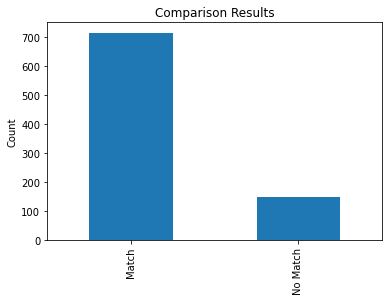

In [72]:
# count the number of True and False values in the 'Match' column
counts = compare_df['is_correct'].value_counts()

# plot the counts as a bar chart
counts.plot(kind='bar')

# add labels to the bars
plt.xticks([0, 1], ['Match', 'No Match'])
plt.ylabel('Count')

# add a title
plt.title('Comparison Results')

plt.show()

In [46]:
print('Accuracy: ', round(compare_df['is_correct'].value_counts()[0] * 100 / y_test.shape[0], 1), '%')

Accuracy:  83.0 %


# Experimenting With Simpler Models 

## Simple LSTM Model 

In [47]:

lstm_model = Sequential([
    LSTM(123, return_sequences=False, input_shape=(train_X.shape[1],train_X.shape[2])),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='softmax')
])

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [48]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 123)               199752    
                                                                 
 dense_8 (Dense)             (None, 64)                7936      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 8)                 264       
                                                                 
Total params: 210,032
Trainable params: 210,032
Non-tr

In [49]:
# Training of the model
history = lstm_model.fit(train_X, train_y, validation_split=0.2, epochs=100, batch_size=512, shuffle=True, verbose=1)

Epoch 1/100
6/6 [==============================] - 3s 228ms/step - loss: 2.0856 - accuracy: 0.1310 - val_loss: 2.0720 - val_accuracy: 0.1575
Epoch 2/100
6/6 [==============================] - 1s 131ms/step - loss: 2.0151 - accuracy: 0.2381 - val_loss: 2.0510 - val_accuracy: 0.1864
Epoch 3/100
6/6 [==============================] - 1s 144ms/step - loss: 1.9540 - accuracy: 0.2920 - val_loss: 2.0306 - val_accuracy: 0.1994
Epoch 4/100
6/6 [==============================] - 1s 132ms/step - loss: 1.8975 - accuracy: 0.3444 - val_loss: 2.0066 - val_accuracy: 0.2269
Epoch 5/100
6/6 [==============================] - 1s 133ms/step - loss: 1.8175 - accuracy: 0.3886 - val_loss: 1.9769 - val_accuracy: 0.2442
Epoch 6/100
6/6 [==============================] - 1s 135ms/step - loss: 1.7296 - accuracy: 0.4298 - val_loss: 1.9397 - val_accuracy: 0.2587
Epoch 7/100
6/6 [==============================] - 1s 136ms/step - loss: 1.6249 - accuracy: 0.4721 - val_loss: 1.9004 - val_accuracy: 0.2818
Epoch 8/100
6

Epoch 59/100
6/6 [==============================] - 1s 120ms/step - loss: 0.0083 - accuracy: 0.9978 - val_loss: 2.3818 - val_accuracy: 0.5650
Epoch 60/100
6/6 [==============================] - 1s 128ms/step - loss: 0.0098 - accuracy: 0.9982 - val_loss: 2.4031 - val_accuracy: 0.5650
Epoch 61/100
6/6 [==============================] - 1s 114ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 2.4973 - val_accuracy: 0.5549
Epoch 62/100
6/6 [==============================] - 1s 119ms/step - loss: 0.0065 - accuracy: 0.9986 - val_loss: 2.4775 - val_accuracy: 0.5795
Epoch 63/100
6/6 [==============================] - 1s 115ms/step - loss: 0.0051 - accuracy: 0.9993 - val_loss: 2.4846 - val_accuracy: 0.5636
Epoch 64/100
6/6 [==============================] - 1s 126ms/step - loss: 0.0089 - accuracy: 0.9978 - val_loss: 2.5081 - val_accuracy: 0.5607
Epoch 65/100
6/6 [==============================] - 1s 140ms/step - loss: 0.0080 - accuracy: 0.9986 - val_loss: 2.4816 - val_accuracy: 0.5679
Epoch 

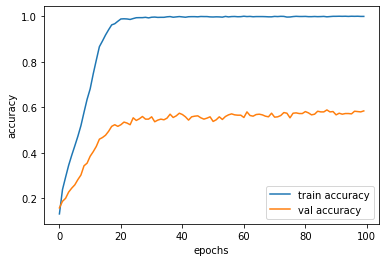

In [50]:
epochs = list(range(100))
acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

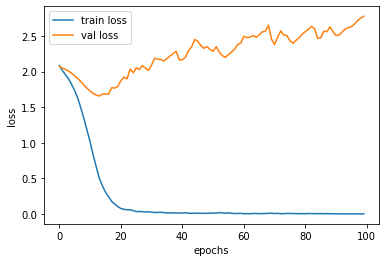

In [51]:
loss = history.history['loss']
val_loss =  history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [52]:
# make predictions on the test data
y_pred = lstm_model.predict(val_X)

# convert the predictions and true labels to class labels
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(val_y, axis=1)

# create a dataframe with y_pred and y_test as columns
acc_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

# add a third column indicating whether the prediction is true or false
acc_df['is_correct'] = np.where(acc_df['y_test'] == acc_df['y_pred'], 'true', 'false')

# display accuracy from the dataframe
print('Accuracy: ', round(acc_df['is_correct'].value_counts()[0] * 100 / y_test.shape[0], 1), '%')

27/27 [==============================] - 1s 10ms/step
Accuracy:  61.9 %


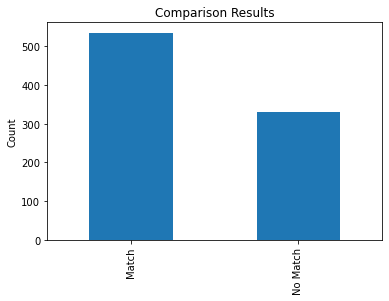

In [53]:
# count the number of True and False values in the 'Match' column
counts = acc_df['is_correct'].value_counts()

# plot the counts as a bar chart
counts.plot(kind='bar')

# add labels to the bars
plt.xticks([0, 1], ['Match', 'No Match'])
plt.ylabel('Count')

# add a title
plt.title('Comparison Results')

plt.show()

In [54]:
# Load the best Model
lstm_model = tf.keras.models.load_model('./model.h5')

In [55]:
# Argmax of predictions
def extract_labels(tensor):
    labels = [np.argmax(prediction) for prediction in tensor]
    return labels

In [56]:
y_pred

array([7, 4, 3, 7, 0, 0, 3, 7, 6, 6, 0, 2, 3, 5, 4, 5, 0, 2, 7, 5, 3, 4,
       2, 7, 4, 2, 4, 3, 6, 0, 6, 6, 3, 7, 4, 4, 7, 7, 1, 5, 7, 5, 0, 0,
       4, 2, 3, 6, 2, 1, 5, 6, 0, 7, 2, 6, 7, 2, 7, 0, 5, 3, 4, 4, 1, 4,
       3, 1, 1, 7, 2, 3, 0, 6, 7, 3, 5, 4, 6, 6, 5, 1, 2, 5, 4, 0, 5, 6,
       7, 7, 1, 0, 6, 7, 4, 3, 0, 0, 4, 3, 3, 4, 3, 3, 5, 5, 7, 7, 5, 0,
       7, 7, 1, 2, 7, 5, 0, 6, 6, 5, 1, 2, 3, 6, 0, 4, 5, 6, 5, 5, 5, 6,
       3, 7, 7, 4, 5, 7, 2, 3, 6, 5, 7, 0, 7, 2, 2, 7, 7, 3, 4, 0, 1, 6,
       6, 2, 0, 5, 1, 3, 7, 6, 6, 3, 5, 3, 6, 1, 2, 6, 0, 1, 2, 3, 5, 5,
       5, 3, 4, 5, 1, 4, 4, 0, 4, 5, 5, 4, 6, 0, 4, 1, 0, 5, 6, 6, 2, 3,
       4, 0, 6, 1, 5, 3, 7, 4, 5, 0, 7, 7, 4, 4, 5, 4, 2, 3, 5, 3, 6, 3,
       6, 2, 2, 7, 7, 1, 3, 6, 2, 7, 6, 7, 7, 4, 5, 4, 3, 3, 4, 0, 1, 0,
       2, 5, 2, 7, 2, 7, 2, 7, 3, 3, 1, 0, 0, 4, 7, 0, 3, 1, 3, 3, 1, 4,
       3, 7, 4, 2, 4, 5, 2, 3, 7, 0, 7, 7, 0, 7, 0, 6, 3, 3, 7, 5, 7, 4,
       7, 6, 2, 3, 3, 6, 0, 1, 3, 0, 7, 7, 3, 0, 6,

27/27 [==============================] - 2s 39ms/step - loss: 1.1456 - categorical_accuracy: 0.8657
Evaluation Score Matrix: 86.57%

27/27 [==============================] - 2s 39ms/step


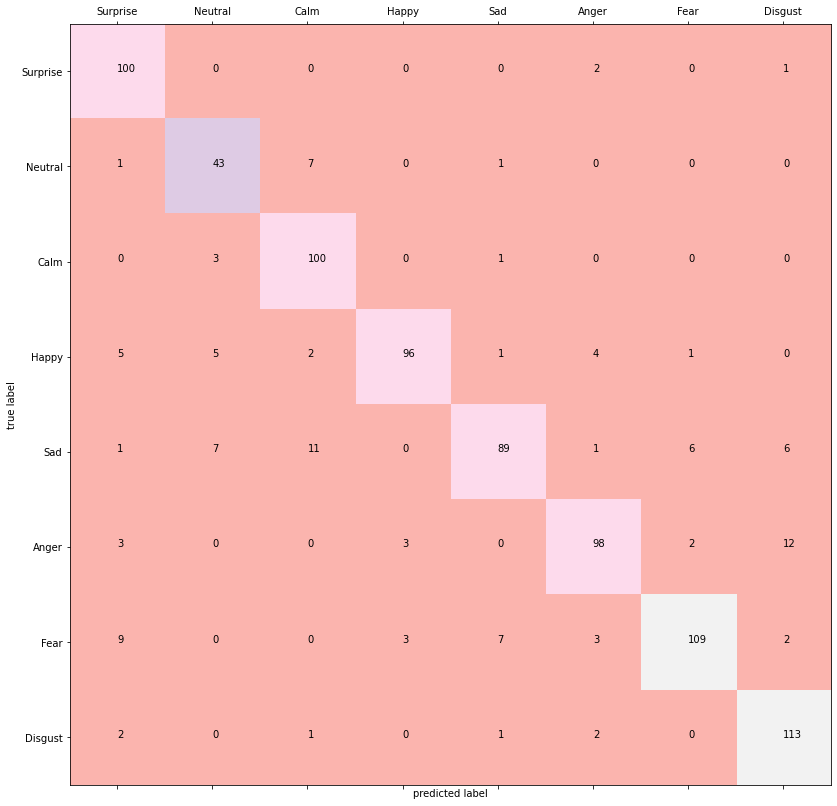

              precision    recall  f1-score   support

    Surprise       0.83      0.97      0.89       103
     Neutral       0.74      0.83      0.78        52
        Calm       0.83      0.96      0.89       104
       Happy       0.94      0.84      0.89       114
         Sad       0.89      0.74      0.81       121
       Anger       0.89      0.83      0.86       118
        Fear       0.92      0.82      0.87       133
     Disgust       0.84      0.95      0.89       119

    accuracy                           0.87       864
   macro avg       0.86      0.87      0.86       864
weighted avg       0.87      0.87      0.86       864



In [57]:
# Evaluate the model again!
score = lstm_model.evaluate(val_X, val_y)
print (f'Evaluation Score Matrix: {np.around(score[1]*100, 2)}%\n')

# Predict the 'val_X' for confusion matrix
pred_y = lstm_model.predict(val_X)

# Extract the labels
val_y = extract_labels(val_y)
pred_y = extract_labels(pred_y)

# Plot the confusion matrix
cm = confusion_matrix(val_y, pred_y)
fig, ax = plt.subplots(1, 1, figsize=(16,14))
ax.matshow(cm, cmap='Pastel1')
for x in range(cm.shape[0]):
    for y in range(cm.shape[1]):
        ax.text(y,x,cm[x,y])
ax.set_xlabel('predicted label')
ax.set_ylabel('true label')
ax.set_xticklabels(['', 'Surprise', 'Neutral', 'Calm', 'Happy', 'Sad', 'Anger', 'Fear', 'Disgust'])
ax.set_yticklabels(['', 'Surprise', 'Neutral', 'Calm', 'Happy', 'Sad', 'Anger', 'Fear', 'Disgust'])
plt.show()
# Print the classification report
print(classification_report(val_y, pred_y, target_names=['Surprise', 'Neutral', 'Calm', 'Happy', \
                                                         'Sad', 'Anger', 'Fear', 'Disgust']))

## Improved Simple Model 

### Add Attention Layer and A Bidirectional Layer 

In [73]:

# Define the input shape
inputs = Input(shape=(train_X.shape[1], train_X.shape[2]))

# Define the LSTM layer
lstm = Bidirectional(LSTM(123, return_sequences=True))(inputs)
lstm = Dropout(0.2)(lstm)
lstm = BatchNormalization()(lstm)

# Define the attention mechanism
attention = Dot(axes=[2, 2])([lstm, lstm])
attention = Activation('softmax')(attention)
attention = Dot(axes=[2, 1])([attention, lstm])
attention = GlobalAveragePooling1D()(attention)

# Define the output layers
output = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(attention)
output = Dropout(0.2)(output)
output = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(output)
output = Dropout(0.2)(output)
output = Dense(8, activation='softmax')(output)

# Define the model
lstm_prime = Model(inputs=inputs, outputs=output)

# Compile the model
lstm_prime.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [59]:
lstm_prime.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 40, 282)]    0           []                               
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 40, 246)     399504      ['input_5[0][0]']                
 )                                                                                                
                                                                                                  
 dropout_6 (Dropout)            (None, 40, 246)      0           ['bidirectional_2[0][0]']        
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 40, 246)     984         ['dropout_6[0][0]']          

In [74]:
# Define early stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')

# Train the model
history = lstm_prime.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(val_X, val_y), callbacks=[early_stop])

Epoch 1/100
108/108 [==============================] - 7s 50ms/step - loss: 3.0144 - accuracy: 0.2769 - val_loss: 2.6574 - val_accuracy: 0.3472
Epoch 2/100
108/108 [==============================] - 5s 44ms/step - loss: 2.1704 - accuracy: 0.4630 - val_loss: 1.9477 - val_accuracy: 0.5104
Epoch 3/100
108/108 [==============================] - 5s 44ms/step - loss: 1.5328 - accuracy: 0.6282 - val_loss: 1.5096 - val_accuracy: 0.5972
Epoch 4/100
108/108 [==============================] - 5s 45ms/step - loss: 1.0124 - accuracy: 0.7888 - val_loss: 1.2285 - val_accuracy: 0.6771
Epoch 5/100
108/108 [==============================] - 5s 46ms/step - loss: 0.6522 - accuracy: 0.9042 - val_loss: 1.1734 - val_accuracy: 0.7106
Epoch 6/100
108/108 [==============================] - 5s 45ms/step - loss: 0.4673 - accuracy: 0.9462 - val_loss: 1.1685 - val_accuracy: 0.7257
Epoch 7/100
108/108 [==============================] - 5s 45ms/step - loss: 0.3636 - accuracy: 0.9696 - val_loss: 1.0731 - val_accuracy:

In [75]:
# Evaluate the model
test_loss, test_acc = lstm_prime.evaluate(val_X, val_y)
print('Test accuracy:', test_acc)

27/27 [==============================] - 0s 15ms/step - loss: 1.2144 - accuracy: 0.7454
Test accuracy: 0.7453703880310059


In [76]:
# make predictions on the test data
y_pred = lstm_prime.predict(val_X)

# convert the predictions and true labels to class labels
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(val_y, axis=1)

# create a dataframe with y_pred and y_test as columns
compares_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

# add a third column indicating whether the prediction is true or false
compares_df['is_correct'] = np.where(compares_df['y_test'] == compares_df['y_pred'], 'true', 'false')

# display accuracy from the dataframe
print('Accuracy: ', round(compare_df['is_correct'].value_counts()[0] * 100 / y_test.shape[0], 1), '%')

27/27 [==============================] - 1s 14ms/step
Accuracy:  83.0 %


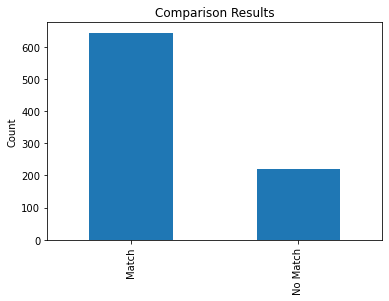

In [77]:
# count the number of True and False values in the 'Match' column
counts = compares_df['is_correct'].value_counts()

# plot the counts as a bar chart
counts.plot(kind='bar')

# add labels to the bars
plt.xticks([0, 1], ['Match', 'No Match'])
plt.ylabel('Count')

# add a title
plt.title('Comparison Results')

plt.show()

27/27 [==============================] - 0s 13ms/step


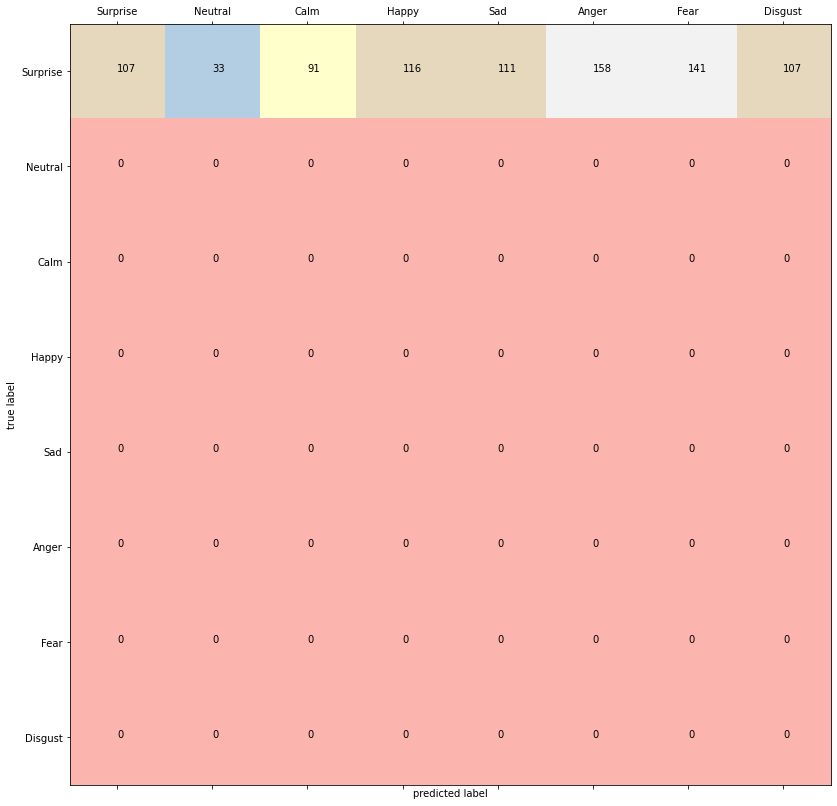

              precision    recall  f1-score   support

    Surprise       1.00      0.12      0.22       864
     Neutral       0.00      0.00      0.00         0
        Calm       0.00      0.00      0.00         0
       Happy       0.00      0.00      0.00         0
         Sad       0.00      0.00      0.00         0
       Anger       0.00      0.00      0.00         0
        Fear       0.00      0.00      0.00         0
     Disgust       0.00      0.00      0.00         0

    accuracy                           0.12       864
   macro avg       0.12      0.02      0.03       864
weighted avg       1.00      0.12      0.22       864



In [79]:
# Predict the 'val_X' for confusion matrix
pred_y = lstm_prime.predict(val_X)

# Extract the labels
val_y = extract_labels(val_y)
pred_y = extract_labels(pred_y)

# Plot the confusion matrix
cm = confusion_matrix(val_y, pred_y)
fig, ax = plt.subplots(1, 1, figsize=(16,14))
ax.matshow(cm, cmap='Pastel1')
for x in range(cm.shape[0]):
    for y in range(cm.shape[1]):
        ax.text(y,x,cm[x,y])
ax.set_xlabel('predicted label')
ax.set_ylabel('true label')
ax.set_xticklabels(['', 'Surprise', 'Neutral', 'Calm', 'Happy', 'Sad', 'Anger', 'Fear', 'Disgust'])
ax.set_yticklabels(['', 'Surprise', 'Neutral', 'Calm', 'Happy', 'Sad', 'Anger', 'Fear', 'Disgust'])
plt.show()

# Print the classification report
print(classification_report(val_y, pred_y, target_names=['Surprise', 'Neutral', 'Calm', 'Happy',\
                                                         'Sad', 'Anger', 'Fear', 'Disgust']))

# Let's Do Traditional ML 

## Extract Relevant Features 

In [97]:


def extract_temporal_features(audio_file, sr=22050):
    # Load audio file
    signal, sr = librosa.load(audio_file, sr=sr)

    # Extract zero-crossing rate
    zcr = librosa.feature.zero_crossing_rate(signal)[0]

    # Extract root-mean-square (RMS) energy
    rms = librosa.feature.rms(y=signal)[0]

    # Extract autocorrelation
    autocorr = librosa.autocorrelate(signal)

    # Extract tempo
    tempo, _ = librosa.beat.beat_track(y=signal, sr=sr)

    # Concatenate features into a single array
    features = np.concatenate([zcr, rms, autocorr, [tempo]])

    return features



def extract_audio_features(file_path):
    # Load audio file
    y, sr = librosa.load(file_path, sr=44100)

    # Extract chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)

    # Extract spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

    # Perform harmonic-percussive separation
    y_harmonic, y_percussive = librosa.effects.hpss(y)

    return chroma, contrast, y_harmonic, y_percussive



In [98]:


def extract_features_from_folder(parent_folder):
    """
    Extracts features from all audio files in a folder and puts them in a pandas DataFrame.
    """
    # Define the columns of the DataFrame
    columns = ['filename', 'zero_crossing_rate', 'rms_energy', 'autocorrelation', 'tempo', 
               'chroma_features', 'spectral_contrast', 'harmonic_percussive_separation']
    
    # Create an empty DataFrame to store the features
    features_df = pd.DataFrame(columns=columns)

    # loop over each subfolder in the parent folder
    for folder in os.listdir(parent_folder):
        folder_path = os.path.join(parent_folder, folder)
        
        # Loop over the audio files in the folder
        for filename in os.listdir(folder_path):
            # Ignore non-audio files
            if not filename.endswith('.wav'):
                continue

            # Extract the features from the audio file
            filepath = os.path.join(folder_path, filename)
            temporal_features = extract_temporal_features(filepath)
            chroma_features, spectral_contrast, harmonic, percussive = extract_audio_features(filepath)

            # Add the features to the DataFrame
            features_df = features_df.append({
                'filename': filename,
                'zero_crossing_rate': temporal_features[0],
                'rms_energy': temporal_features[1],
                'autocorrelation': temporal_features[2],
                'tempo': temporal_features[3],
                'chroma_features': chroma_features,
                'spectral_contrast': spectral_contrast,
                'harmonic_percussive_separation': (harmonic, percussive)
            }, ignore_index=True)
    
    return features_df



In [99]:
features_df = extract_features_from_folder(parent_folder)
features_df

filename  zero_crossing_rate  rms_energy  \
0     03-01-01-01-01-01-01.wav            0.110352    0.221680   
1     03-01-01-01-01-02-01.wav            0.214355    0.355469   
2     03-01-01-01-02-01-01.wav            0.200684    0.311523   
3     03-01-01-01-02-02-01.wav            0.361328    0.524414   
4     03-01-02-01-01-01-01.wav            0.349121    0.532715   
...                        ...                 ...         ...   
1435  03-01-08-01-02-02-24.wav            0.000000    0.000000   
1436  03-01-08-02-01-01-24.wav            0.000000    0.000000   
1437  03-01-08-02-01-02-24.wav            0.000000    0.000000   
1438  03-01-08-02-02-01-24.wav            0.000000    0.000000   
1439  03-01-08-02-02-02-24.wav            0.000000    0.000000   

      autocorrelation     tempo  \
0            0.337402  0.460449   
1            0.517578  0.486328   
2            0.479004  0.473145   
3            0.680664  0.674805   
4            0.724609  0.708008   
...               ...       ...   
1435         0.000000  0.000000   
1436         0.000000  0.000000   
1437         0.000000  0.000000   
1438         0.000000  0.000000   
1439         0.000000  0.000000   

                                        chroma_features  \
0     [[0.25333717, 0.25335616, 0.43104988, 0.971008...   
1     [[0.80919075, 0.72405154, 0.8033917, 0.9614835...   
2     [[0.8002467, 0.9094826, 0.88145214, 1.0, 0.985...   
3     [[0.3504174, 0.35051852, 0.39450538, 0.2657401...   
4     [[0.7478954, 0.77994156, 0.8220432, 0.8438466,...   
...                                                 ...   
1435  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1436  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1437  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1438  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1439  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                      spectral_contrast  \
0     [[0.2306790381747561, 0.2269606830267108, 4.50...   
1     [[4.739490956780372, 8.083624933769038, 4.6400...   
2     [[13.393387994026632, 14.788142924089225, 13.2...   
3     [[6.992929357026398, 10.69526430081713, 14.760...   
4     [[4.636419102836445, 11.282552088342744, 6.959...   
...                                                 ...   
1435  [[14.038884590958574, 14.038884590958574, 14.0...   
1436  [[13.643029336507752, 13.643029336507752, 13.6...   
1437  [[15.280888500084586, 15.280888500084586, 15.2...   
1438  [[17.33410842992319, 17.33410842992319, 17.334...   
1439  [[18.85117317608715, 18.85117317608715, 18.851...   

                         harmonic_percussive_separation  
0     ([-4.2951493e-07, 3.2055976e-07, -1.6451284e-0...  
1     ([1.7226741e-06, -3.116436e-06, -9.191971e-06,...  
2     ([2.2276541e-05, 2.0269066e-05, 1.8647725e-06,...  
3     ([1.655831e-05, 1.581355e-05, 1.8292469e-05, 1...  
4     ([1.35978935e-05, 2.5354967e-07, -4.2032343e-0...  
...                                                 ...  
1435  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1436  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1437  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1438  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1439  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  

[1440 rows x 8 columns]

In [100]:
features_df['mfcc'] = data['mfcc']
features_df['emotion'] = data['emotion']
features_df['intensity'] = data['intensity']
features_df

filename  zero_crossing_rate  rms_energy  \
0     03-01-01-01-01-01-01.wav            0.110352    0.221680   
1     03-01-01-01-01-02-01.wav            0.214355    0.355469   
2     03-01-01-01-02-01-01.wav            0.200684    0.311523   
3     03-01-01-01-02-02-01.wav            0.361328    0.524414   
4     03-01-02-01-01-01-01.wav            0.349121    0.532715   
...                        ...                 ...         ...   
1435  03-01-08-01-02-02-24.wav            0.000000    0.000000   
1436  03-01-08-02-01-01-24.wav            0.000000    0.000000   
1437  03-01-08-02-01-02-24.wav            0.000000    0.000000   
1438  03-01-08-02-02-01-24.wav            0.000000    0.000000   
1439  03-01-08-02-02-02-24.wav            0.000000    0.000000   

      autocorrelation     tempo  \
0            0.337402  0.460449   
1            0.517578  0.486328   
2            0.479004  0.473145   
3            0.680664  0.674805   
4            0.724609  0.708008   
...               ...       ...   
1435         0.000000  0.000000   
1436         0.000000  0.000000   
1437         0.000000  0.000000   
1438         0.000000  0.000000   
1439         0.000000  0.000000   

                                        chroma_features  \
0     [[0.25333717, 0.25335616, 0.43104988, 0.971008...   
1     [[0.80919075, 0.72405154, 0.8033917, 0.9614835...   
2     [[0.8002467, 0.9094826, 0.88145214, 1.0, 0.985...   
3     [[0.3504174, 0.35051852, 0.39450538, 0.2657401...   
4     [[0.7478954, 0.77994156, 0.8220432, 0.8438466,...   
...                                                 ...   
1435  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1436  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1437  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1438  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1439  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                      spectral_contrast  \
0     [[0.2306790381747561, 0.2269606830267108, 4.50...   
1     [[4.739490956780372, 8.083624933769038, 4.6400...   
2     [[13.393387994026632, 14.788142924089225, 13.2...   
3     [[6.992929357026398, 10.69526430081713, 14.760...   
4     [[4.636419102836445, 11.282552088342744, 6.959...   
...                                                 ...   
1435  [[14.038884590958574, 14.038884590958574, 14.0...   
1436  [[13.643029336507752, 13.643029336507752, 13.6...   
1437  [[15.280888500084586, 15.280888500084586, 15.2...   
1438  [[17.33410842992319, 17.33410842992319, 17.334...   
1439  [[18.85117317608715, 18.85117317608715, 18.851...   

                         harmonic_percussive_separation  \
0     ([-4.2951493e-07, 3.2055976e-07, -1.6451284e-0...   
1     ([1.7226741e-06, -3.116436e-06, -9.191971e-06,...   
2     ([2.2276541e-05, 2.0269066e-05, 1.8647725e-06,...   
3     ([1.655831e-05, 1.581355e-05, 1.8292469e-05, 1...   
4     ([1.35978935e-05, 2.5354967e-07, -4.2032343e-0...   
...                                                 ...   
1435  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1436  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1437  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1438  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1439  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                   mfcc    emotion intensity  
0     [[-1001.3932749662753, -1001.3932749662753, -1...    neutral    normal  
1     [[-991.081171202478, -989.5370761616882, -990....    neutral    normal  
2     [[-988.3008575798004, -988.3008575798004, -988...    neutral    normal  
3     [[-989.790157887361, -989.790157887361, -989.7...    neutral    normal  
4     [[-1020.813650186152, -1020.813650186152, -102...       calm    normal  
...                                                 ...        ...       ...  
1435  [[-888.8919778169295, -888.8919778169295, -888...  surprised    normal  
1436  [[-810.9191128908011, -810.9191128908011, -

In [101]:
df = features_df

array_cols = ['chroma_features', 'spectral_contrast', 'harmonic_percussive_separation', 'mfcc']

def stats(df, cols):
    
    for col in cols:
        
        means = []
        stds = []
        medians = []
        
        for i in range(df.shape[0]):
            
            means.append(np.mean(df[col][i]))
            stds.append(np.std(df[col][i]))
            medians.append(np.median(df[col][i]))
            
        df[f'{col}_means'] = means
        df[f'{col}_stds'] = stds
        df[f'{col}_medians'] = medians
        
    return df

df = stats(df, array_cols)
df.head()

filename  zero_crossing_rate  rms_energy  autocorrelation  \
0  03-01-01-01-01-01-01.wav            0.110352    0.221680         0.337402   
1  03-01-01-01-01-02-01.wav            0.214355    0.355469         0.517578   
2  03-01-01-01-02-01-01.wav            0.200684    0.311523         0.479004   
3  03-01-01-01-02-02-01.wav            0.361328    0.524414         0.680664   
4  03-01-02-01-01-01-01.wav            0.349121    0.532715         0.724609   

      tempo                                    chroma_features  \
0  0.460449  [[0.25333717, 0.25335616, 0.43104988, 0.971008...   
1  0.486328  [[0.80919075, 0.72405154, 0.8033917, 0.9614835...   
2  0.473145  [[0.8002467, 0.9094826, 0.88145214, 1.0, 0.985...   
3  0.674805  [[0.3504174, 0.35051852, 0.39450538, 0.2657401...   
4  0.708008  [[0.7478954, 0.77994156, 0.8220432, 0.8438466,...   

                                   spectral_contrast  \
0  [[0.2306790381747561, 0.2269606830267108, 4.50...   
1  [[4.739490956780372, 8.083624933769038, 4.6400...   
2  [[13.393387994026632, 14.788142924089225, 13.2...   
3  [[6.992929357026398, 10.69526430081713, 14.760...   
4  [[4.636419102836445, 11.282552088342744, 6.959...   

                      harmonic_percussive_separation  \
0  ([-4.2951493e-07, 3.2055976e-07, -1.6451284e-0...   
1  ([1.7226741e-06, -3.116436e-06, -9.191971e-06,...   
2  ([2.2276541e-05, 2.0269066e-05, 1.8647725e-06,...   
3  ([1.655831e-05, 1.581355e-05, 1.8292469e-05, 1...   
4  ([1.35978935e-05, 2.5354967e-07, -4.2032343e-0...   

                                                mfcc  emotion  ...  \
0  [[-1001.3932749662753, -1001.3932749662753, -1...  neutral  ...   
1  [[-991.081171202478, -989.5370761616882, -990....  neutral  ...   
2  [[-988.3008575798004, -988.3008575798004, -988...  neutral  ...   
3  [[-989.790157887361, -989.790157887361, -989.7...  neutral  ...   
4  [[-1020.813650186152, -1020.813650186152, -102...     calm  ...   

  chroma_features_medians  spectral_contrast_means  spectral_contrast_stds  \
0                0.705841                17.193952               11.489136   
1                0.675147                17.584537               11.474746   
2                0.673441                17.418303               11.071463   
3                0.634013                17.692282               11.211409   
4                0.654098                17.155137               11.415869   

   spectral_contrast_medians  harmonic_percussive_separation_means  \
0                  13.765804                          4.574968e-07   
1                  13.842887                          3.568902e-07   
2                  13.844601                          4.777673e-07   
3                  14.202799                          4.588064e-07   
4                  13.850011                          4.054364e-07   

   harmonic_percussive_separation_stds  \
0                             0.002329   
1                             0.002567   
2                             0.002912   
3                             0.002869   
4                             0.001743   

   harmonic_percussive_separation_medians  mfcc_means   mfcc_stds  \
0                           -2.668581e-09  -17.872639  135.251945   
1                           -5.288419e-09  -17.549839  133.080541   
2                           -2.887158e-09  -17.926600  133.790592   
3                           -4.988113e-09  -17.780367  134.282539   
4                           -1.384243e-12  -17.572926  135.315055   

   mfcc_medians  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  

[5 rows x 23 columns]

In [116]:
# define labels
inverted_dict = {v: k for k, v in emotions_dict.items()}
y = df['emotion']
y = np.array([inverted_dict[x] for x in y])

In [117]:
X = df.drop(['filename', 'emotion'], axis=1)

# Use get_dummies() to create dummy variables for column 'intensity'
dummy_df = pd.get_dummies(df['intensity'])

# Join the dummy variables to the original DataFrame
X = pd.concat([X, dummy_df], axis=1)


pd.set_option('display.max_columns', None)
X

zero_crossing_rate  rms_energy  autocorrelation     tempo  \
0               0.110352    0.221680         0.337402  0.460449   
1               0.214355    0.355469         0.517578  0.486328   
2               0.200684    0.311523         0.479004  0.473145   
3               0.361328    0.524414         0.680664  0.674805   
4               0.349121    0.532715         0.724609  0.708008   
...                  ...         ...              ...       ...   
1435            0.000000    0.000000         0.000000  0.000000   
1436            0.000000    0.000000         0.000000  0.000000   
1437            0.000000    0.000000         0.000000  0.000000   
1438            0.000000    0.000000         0.000000  0.000000   
1439            0.000000    0.000000         0.000000  0.000000   

                                        chroma_features  \
0     [[0.25333717, 0.25335616, 0.43104988, 0.971008...   
1     [[0.80919075, 0.72405154, 0.8033917, 0.9614835...   
2     [[0.8002467, 0.9094826, 0.88145214, 1.0, 0.985...   
3     [[0.3504174, 0.35051852, 0.39450538, 0.2657401...   
4     [[0.7478954, 0.77994156, 0.8220432, 0.8438466,...   
...                                                 ...   
1435  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1436  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1437  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1438  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1439  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                      spectral_contrast  \
0     [[0.2306790381747561, 0.2269606830267108, 4.50...   
1     [[4.739490956780372, 8.083624933769038, 4.6400...   
2     [[13.393387994026632, 14.788142924089225, 13.2...   
3     [[6.992929357026398, 10.69526430081713, 14.760...   
4     [[4.636419102836445, 11.282552088342744, 6.959...   
...                                                 ...   
1435  [[14.038884590958574, 14.038884590958574, 14.0...   
1436  [[13.643029336507752, 13.643029336507752, 13.6...   
1437  [[15.280888500084586, 15.280888500084586, 15.2...   
1438  [[17.33410842992319, 17.33410842992319, 17.334...   
1439  [[18.85117317608715, 18.85117317608715, 18.851...   

                         harmonic_percussive_separation  \
0     ([-4.2951493e-07, 3.2055976e-07, -1.6451284e-0...   
1     ([1.7226741e-06, -3.116436e-06, -9.191971e-06,...   
2     ([2.2276541e-05, 2.0269066e-05, 1.8647725e-06,...   
3     ([1.655831e-05, 1.581355e-05, 1.8292469e-05, 1...   
4     ([1.35978935e-05, 2.5354967e-07, -4.2032343e-0...   
...                                                 ...   
1435  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1436  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1437  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1438  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1439  ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                   mfcc intensity  \
0     [[-1001.3932749662753, -1001.3932749662753, -1...    normal   
1     [[-991.081171202478, -989.5370761616882, -990....    normal   
2     [[-988.3008575798004, -988.3008575798004, -988...    normal   
3     [[-989.790157887361, -989.790157887361, -989.7...    normal   
4     [[-1020.813650186152, -1020.813650186152, -102...    normal   
...                                                 ...       ...   
1435  [[-888.8919778169295, -888.8919778169295, -888...    normal   
1436  [[-810.9191128908011, -810.9191128908011, -810...    strong   
1437  [[-873.4396229825027, -873.4396229825027, -873...    strong   
1438  [[-844.4682163331069, -844.4682163331069, -843...    strong   
1439  [[-662.4847860705357, -629.1194899581678, -635...    strong   

      chroma_features_means  chroma_features_stds  chroma_features_medians  \
0                  0.637217              0.280216                 0.705841   
1                  0.620907              0.281217                 0.675147   
2          

In [118]:
X.drop(['mfcc', 'intensity', 'chroma_features', 'spectral_contrast', 'harmonic_percussive_separation'], axis=1, inplace=True)

In [119]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-0.37971675, -0.10455716,  0.05085963, ...,  0.13606168,
         0.93541435, -0.93541435],
       [ 0.36855801,  0.55495928,  0.73409712, ...,  0.13606168,
         0.93541435, -0.93541435],
       [ 0.27019325,  0.33832979,  0.58782135, ...,  0.13606168,
         0.93541435, -0.93541435],
       ...,
       [-1.17366086, -1.19733257, -1.22859051, ...,  0.01363815,
        -1.06904497,  1.06904497],
       [-1.17366086, -1.19733257, -1.22859051, ...,  0.00429482,
        -1.06904497,  1.06904497],
       [-1.17366086, -1.19733257, -1.22859051, ...,  0.13606168,
        -1.06904497,  1.06904497]])

# Experimenting With Traditional Models 

## Unsupervised: Bayesian GMM, Hidden Markov Models 

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=True)

In [107]:
# Train a Bayesian GMM on the extracted features
gmm = BayesianGaussianMixture(n_components=8, weight_concentration_prior=1e-2, covariance_type='full', max_iter=500)
gmm.fit(X)

# Predict the emotions in new audio signals using the trained GMM
predicted_emotions = gmm.predict(X)
print(predicted_emotions)

[0 0 0 ... 2 2 2]


In [108]:
# transform y type to int
y = y.astype(int)

# Compute the accuracy of the predictions
accuracy = accuracy_score(y, predicted_emotions)

print("Accuracy: {:.2f}%".format(accuracy * 100))

# Compute the F1 score of the predictions
f1 = f1_score(y, predicted_emotions, average='macro')

print("F1 score: {:.4f}".format(f1))

Accuracy: 11.88%
F1 score: 0.1037


In [109]:
n_states = 8 # number of emotional states
model = GaussianHMM(n_components=n_states, covariance_type="diag")

# Fit the model to the training data
model.fit(X)

# Predict labels for the test data
predicted_emotions = model.predict(X)

# Compute the accuracy of the predictions
accuracy = accuracy_score(y, predicted_emotions)

print("Accuracy: {:.2f}%".format(accuracy * 100))

# Compute the F1 score of the predictions
f1 = f1_score(y, predicted_emotions, average='weighted')

print("F1 score: {:.4f}".format(f1))

Accuracy: 13.19%
F1 score: 0.1143


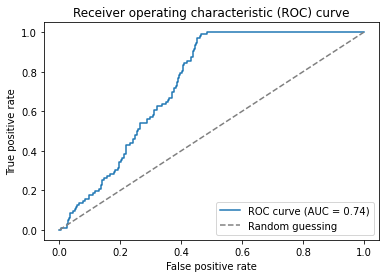

In [110]:
# Compute the probabilities for each class using your HMM model
probs = model.predict_proba(X)

# Compute the fpr, tpr, and thresholds for each class
fpr, tpr, thresholds = roc_curve(y, probs[:, 1], pos_label=1)

# Compute the AUC score for the class
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guessing')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend()
plt.show()

## Supervised: SVM, GradientBoosting & RandomForest

In [111]:
# Create SVM model
svm = svm.SVC(kernel='linear', C=1)

# Train SVM model
svm.fit(X_train, y_train)

# Predict labels on testing set
y_pred = svm.predict(X_test)

# Evaluate the SVM classifier
accuracy = accuracy_score(y_test, y_pred)

# Compute the precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 score: ', f1_score)
print('Train Score: ', svm.score(X_train, y_train))

Accuracy:  0.41203703703703703
Precision:  0.40676760230328507
Recall:  0.4213824449704356
F1 score:  0.4032566163053578
Train Score:  0.49007936507936506


In [112]:
# Define the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Train the Random Forest classifier
rf.fit(X_train, y_train)

# Evaluate the Random Forest classifier
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Compute the precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 score: ', f1_score)
print('Train Score: ', rf.score(X_train, y_train))

Accuracy:  0.3611111111111111
Precision:  0.3733175041469434
Recall:  0.36646657683959727
F1 score:  0.31644547687946023
Train Score:  0.628968253968254


In [123]:
# Initialize the GradientBoostingClassifier with some hyperparameters
gbt = GradientBoostingClassifier(
    n_estimators=1000,  # number of trees in the ensemble
    learning_rate=0.1,  # shrinkage parameter
    max_depth=3,        # maximum depth of each tree
    min_samples_split=2,# minimum number of samples required to split a node
    min_samples_leaf=1, # minimum number of samples required to form a leaf
    subsample=0.8,      # fraction of samples used to train each tree
    random_state=42
)

# Train the model using early stopping
gbt.fit(X_train, y_train)
for stage, y_pred in enumerate(gbt.staged_predict(X_test)):
    score = accuracy_score(y_test, y_pred)
    if score == max(gbt.train_score_):
        break  # stop training at the point of best validation performance

# make predictions on the test data
predicted_labels = gbt.predict(X_test)

# evaluate the performance of the classifier
accuracy = accuracy_score(y_test, predicted_labels)
# f1score = f1_score(y_test, predicted_labels, average='macro')

print("Accuracy: {:.2f}%".format(accuracy * 100))
# print("F1 Score: {:.2f}%".format(f1score * 100))
print('Train Score: ', gbt.score(X_train, y_train))

Accuracy: 44.44%
Train Score:  1.0


In [127]:
y_test

array(['7', '5', '6', '0', '0', '6', '1', '1', '3', '7', '4', '3', '5',
       '4', '6', '6', '7', '6', '5', '4', '4', '4', '7', '3', '3', '7',
       '6', '0', '3', '3', '3', '3', '5', '1', '7', '2', '6', '5', '4',
       '0', '2', '4', '7', '7', '2', '1', '2', '2', '2', '0', '5', '7',
       '0', '0', '7', '0', '7', '6', '4', '4', '4', '4', '3', '2', '3',
       '2', '0', '5', '7', '5', '1', '7', '3', '5', '0', '4', '1', '4',
       '6', '7', '7', '4', '7', '6', '3', '6', '5', '6', '2', '6', '3',
       '6', '1', '2', '4', '7', '6', '6', '4', '6', '0', '6', '5', '6',
       '3', '4', '1', '7', '0', '6', '1', '0', '2', '4', '5', '6', '6',
       '7', '6', '1', '4', '4', '4', '6', '6', '7', '2', '7', '3', '2',
       '5', '2', '7', '4', '7', '0', '7', '0', '0', '2', '4', '5', '2',
       '6', '5', '1', '3', '7', '6', '3', '5', '3', '2', '4', '7', '4',
       '3', '2', '3', '2', '4', '6', '6', '4', '3', '2', '4', '7', '0',
       '6', '3', '0', '0', '3', '6', '6', '5', '3', '0', '3', '7

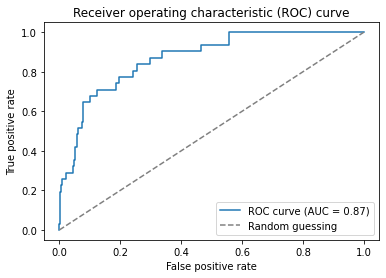

In [128]:
# Compute the probabilities for each class using your GBT model
probs = gbt.predict_proba(X_test)
y_test = y_test.astype('int')

# Compute the fpr, tpr, and thresholds for each class
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1], pos_label=1)

# Compute the AUC score for the class
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guessing')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend()
plt.show()

#  <i> If Worth Mentioning </i> 

<div style="display: flex; justify-content: center;"><img src="1_voV0s4n6oewS7SH0x6ugzQ.jpeg" width=900px /></div>

# Attention is All You Need!

## MultiModal Multi-Head Attention Transformer

In [129]:


def Transformer(num_encoder_layers, num_decoder_layers, d_model, num_heads, d_ff, src_vocab_size, tgt_vocab_size, max_len, dropout_rate, audio_dim=None, num_classes=None):
    # Define input layers
    src_input = Input(shape=(max_len,), name='src_input')
    tgt_input = Input(shape=(max_len,), name='tgt_input')
    src_mask_input = Input(shape=(1, 1, max_len), name='src_mask_input')
    tgt_mask_input = Input(shape=(1, max_len, max_len), name='tgt_mask_input')
    
    # Embedding layers
    src_embedding = Embedding(input_dim=src_vocab_size, output_dim=d_model)(src_input)
    tgt_embedding = Embedding(input_dim=tgt_vocab_size, output_dim=d_model)(tgt_input)
    
    # Positional Encoding
    pos_encoding = positional_encoding(max_len, d_model)
    src_embedding = src_embedding + pos_encoding[:, :max_len, :]
    tgt_embedding = tgt_embedding + pos_encoding[:, :max_len, :]
    
    # Apply dropout to embeddings
    src_embedding = Dropout(rate=dropout_rate)(src_embedding)
    tgt_embedding = Dropout(rate=dropout_rate)(tgt_embedding)
    
    # Add convolutional layer for audio input
    if audio_dim is not None:
        audio_input = Input(shape=(audio_dim, max_len), name='audio_input')
        conv_layer = TimeDistributed(Convolution1D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))(audio_input)
        conv_layer = TimeDistributed(MaxPooling1D(pool_size=2))(conv_layer)
        conv_layer = TimeDistributed(Flatten())(conv_layer)
        conv_layer = TimeDistributed(Dense(units=d_model, activation='relu'))(conv_layer)
        
        # Concatenate audio input with source embedding
        src_embedding = Concatenate(axis=-1)([src_embedding, conv_layer])
    
    # Encode the source sequence
    encoder_output = src_embedding
    for i in range(num_encoder_layers):
        encoder_output = encoder_layer(encoder_output, src_mask_input, num_heads, d_ff, dropout_rate)
        
    # Encode the target sequence
    decoder_output = tgt_embedding
    for i in range(num_decoder_layers):
        decoder_output = decoder_layer(decoder_output, encoder_output, tgt_mask_input, src_mask_input, num_heads, d_ff, dropout_rate)
        
    # Final linear layer
    output = Dense(units=tgt_vocab_size)(decoder_output)
    
    # Add classification layer if num_classes is not None
    if num_classes is not None:
        output = Dense(units=num_classes, activation='softmax')(decoder_output)
    
    # Define the model
    inputs = [src_input, tgt_input, src_mask_input, tgt_mask_input]
    if audio_dim is not None:
        inputs.append(audio_input)
    model = Model(inputs=inputs, outputs=output)
    return model


def positional_encoding(max_len, d_model):
    # Calculate the positional encoding
    position = tf.range(max_len, dtype=tf.float32)[:, tf.newaxis]
    div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / d_model))
    sin_term = tf.sin(position * div_term)
    cos_term = tf.cos(position * div_term)
    pos_encoding = tf.concat([sin_term, cos_term], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)


def scaled_dot_product_attention(q, k, v, mask=None):
    # Calculate the attention scores
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_scores = matmul_qk / tf.math.sqrt(dk)
    
    # Apply the mask
    if mask is not None:
        scaled_scores += (mask * -1e9)
    
    # Apply the softmax function
    attention_weights = tf.nn.softmax(scaled_scores, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights


def multihead_attention(query, key, value, num_heads, d_model, mask=None):
    # Calculate the query, key, and value projections
    q = Dense(units=d_model)(query)
    k = Dense(units=d_model)(key)
    v = Dense(units=d_model)(value)
    
    # Split the projections into multiple heads
    q = tf.reshape(q, shape=(-1, tf.shape(q)[1], num_heads, d_model // num_heads))
    k = tf.reshape(k, shape=(-1, tf.shape(k)[1], num_heads, d_model // num_heads))
    v = tf.reshape(v, shape=(-1, tf.shape(v)[1], num_heads, d_model // num_heads))
    
    # Transpose the dimensions for batched computation
    q = tf.transpose(q, perm=[0, 2, 1, 3])
    k = tf.transpose(k, perm=[0, 2, 1, 3])
    v = tf.transpose(v, perm=[0, 2, 1, 3])
    
    # Calculate the attention scores for each head
    attention_output, attention_weights = scaled_dot_product_attention(q, k, v, mask)
    
    # Concatenate the attention outputs from each head
    attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])
    attention_output = tf.reshape(attention_output, shape=(-1, tf.shape(attention_output)[1], d_model))
    
    # Apply a final linear transformation to the concatenated outputs
    output = Dense(units=d_model)(attention_output)
    return output, attention_weights


def encoder_layer(inputs, mask, num_heads, d_ff, dropout_rate):
    # Apply multihead attention
    attention_output, _ = multihead_attention(inputs, inputs, inputs, num_heads, d_model)
    
    # Add a residual connection and apply layer normalization
    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    
    # Apply a feedforward network
    ff_output = TimeDistributed(Dense(units=d_ff, activation='relu'))(attention_output)
    ff_output = Dropout(rate=dropout_rate)(ff_output)
    ff_output = TimeDistributed(Dense(units=d_model))(ff_output)
    
    # Add a residual connection and apply layer normalization
    encoder_output = LayerNormalization(epsilon=1e-6)(attention_output + ff_output)
    
    # Apply the mask to the encoder output
    encoder_output *= mask
    return encoder_output


def decoder_layer(inputs, encoder_output, tgt_mask, src_mask, num_heads, d_ff, dropout_rate):
    # Apply masked multihead attention to the decoder inputs
    tgt_attention_output, _ = multihead_attention(inputs, inputs, inputs, num_heads, d_model, mask=tgt_mask)
    
    # Add a residual connection and apply layer normalization
    tgt_attention_output = LayerNormalization(epsilon=1e-6)(inputs + tgt_attention_output)
    
    # Apply multihead attention to the encoder output and decoder inputs
    src_attention_output, _ = multihead_attention(tgt_attention_output, encoder_output, encoder_output, num_heads, d_model, mask=src_mask)
    
    # Add a residual connection and apply layer normalization
    src_attention_output = LayerNormalization(epsilon=1e-6)(tgt_attention_output + src_attention_output)
    
    # Apply a feedforward network
    ff_output = TimeDistributed(Dense(units=d_ff, activation='relu'))(src_attention_output)
    ff_output = Dropout(rate=dropout_rate)(ff_output)
    ff_output = TimeDistributed(Dense(units=d_model))(ff_output)
    
    # Add a residual connection and apply layer normalization
    decoder_output = LayerNormalization(epsilon=1e-6)(src_attention_output + ff_output)
    
    # Apply the mask to the decoder output
    decoder_output *= tgt_mask
    return decoder_output



# Famous Pre-Trained Models

## Google's VGGish

In [130]:
%%capture
def VGGish():
    '''
    
    Load VGGish from Github source 
    
    
    '''
    #from vggish import VGGish

    # Load VGGish model
    vggish = VGGish(include_top=False, load_weights=True)


    # Freeze pre-trained layers
    for layer in vggish.layers:
        layer.trainable = False

    # Add new output layer
    x = vggish.output
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=vggish.input, outputs=predictions)


    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


    # Unfreeze some layers for fine-tuning
    for layer in model.layers[-4:]:
        layer.trainable = True

    # Recompile the model with a lower learning rate
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Continue training the model
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


def extract_features_from_waveforms(waveforms, vggish_input, sr=44100, scale=True):
    """
    Extracts VGGish features from a list of audio waveforms.

    Args:
        waveforms (list): A list of audio waveforms as numpy arrays.
        vggish_input (VGGishInput): VGGishInput object to convert audio to examples for VGGish.
        sr (int): Sampling rate of the audio waveforms.
        scale (bool): If True, scale the VGGish features using StandardScaler.

    Returns:
        numpy.ndarray: A 2D numpy array of VGGish features for each audio waveform.
    """

    # Define segment length as 3 seconds
    segment_length = 3 * sr

    # Extract features from each waveform segment
    features = []
    for waveform in waveforms:
        # Split waveform into 3-second segments
        segments = []
        for i in range(0, len(waveform), segment_length):
            segment = waveform[i:i+segment_length]
            if len(segment) == segment_length:
                segments.append(segment)

        # Extract features from each segment
        segment_features = []
        for segment in segments:
            # Convert audio to examples for VGGish
            examples_batch = vggish_input.waveform_to_examples(segment, sr)

            # Extract features using VGGish
            feature_batch = vggish_input.features_extractor(examples_batch)

            # Append features to list
            segment_features.append(feature_batch)

        # Convert features to numpy array
        segment_features = np.array(segment_features)

        # Reshape features to be 2D array
        num_segments = segment_features.shape[0]
        num_features = segment_features.shape[1] * segment_features.shape[2]
        segment_features = segment_features.reshape(num_segments, num_features)

        # Append segment features to list
        features.append(segment_features)

    # Convert features to numpy array
    features = np.array(features)

    # Flatten features into a single 2D array
    num_waveforms = features.shape[0]
    num_segments = features.shape[1]
    num_features = features.shape[2]
    features = features.reshape(num_waveforms * num_segments, num_features)

    # Scale features if necessary
    if scale:
        scaler = StandardScaler()
        features = scaler.fit_transform(features)

    return features


<h1> Conclusion </h1>

### <font color='#008B8B'> <p style="line-height: 1.3;"> Based on the work in this notebook, and some research study, we can sum up the conclusions as follows: "Deep Learning Models obviously outperformed Traditional ML Models (Supervised/Unsupervised). Initially, my first try was a CNN combined to a LSTM (particulary Bidirectional LSTM). However, Simpler ANN architecture if properly improved, was more suitable for the task with minimal overfitting when controled. Some research papers, like <i>"Attention is All You Need!"</i>,  suggest that Attention Mechanism and especially when combined with a transformer (namely <strong>Multi-Head Attention Transformer</strong>) could be a better approach to perform SER. Moreover, Transfer learning can be also applied using some famous pretrained models, for speech recognition, like Google's VGGish. Consequently, these model when perfectly tuned can return some remarkable results as well. Overall, Speech Emotion Recognition can be a challenging task for diverse reasons, such as the wise use of relevant features, the application of appropriate preprocessing techniques, the careful selection of features and the choice of the right model. Yet, the process can be somehow time consuming, and require several experimental iterations, to get accurate outcomes."

#### <font color= '#A9A9A9'>  <strong> The run time of this project overall is approximately around 3 hours </strong> </font>

# <font color='#556B2F'> <h1> <i>Thank You!</i>

<div style="display: flex; justify-content: center;"><img src="abstract-adult-background-blank.jpg" /></div>